# ノート 3: 訓練データ、検証データ、テストデータ

### 目標: 訓練、検証、テストデータの分割方法について理解する

### 背景

論文の 3.b 節でデータセットを訓練データ、検証データ、テストデータに分割することの重要性について議論しました。
なぜ分割するのかを理解できていない場合は 3.b 節を復習してください。このノートでは分割方法について学びます。


### Step 1: パッケージのインポートとデータの読み込み


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'

In [6]:
# パーセンタイルを求めたサンプルデータの読み込み
# parse_dates=True とすると日時文字列をdatetime型として読み込める
df = pd.read_csv(
    "../datasets/sevir/IR_stats_master.csv",
    index_col=0,
    low_memory=False,
    parse_dates=True,
)
# 整数として保存されているのでスケールを戻す
keys = list(df.keys()[:-1])  # 最後の行はイベントラベルなので除く
df[keys] = df[keys] * 1e-2
# 外れ値の除去（詳細はNotebook 02を参照）
df = df.where(df.q000 > -100)
# インデックス順に並べ替える
df = df.sort_index()

df.head()

,q000,q001,q010,q025,q050,q075,q090,q099,q100,event
2018-02-04 16:40:00,-61.31,-59.45,-55.30,-52.59,-47.00,-36.92,-26.560,-4.4163,15.19,Thunderstorm Wind
2018-02-04 16:45:00,-61.90,-59.13,-55.37,-52.52,-47.68,-38.00,-26.753,-6.9400,15.32,Thunderstorm Wind
2018-02-04 16:50:00,-61.16,-58.93,-55.35,-52.55,-48.17,-39.07,-27.013,-8.8400,15.62,Thunderstorm Wind
2018-02-04 16:55:00,-61.63,-58.87,-55.38,-52.68,-48.34,-40.16,-27.030,-8.9163,14.27,Thunderstorm Wind
2018-02-04 17:00:00,-61.67,-58.82,-55.42,-52.81,-48.38,-40.75,-27.240,-9.0526,6.57,Thunderstorm Wind


In [7]:
# 教師データとして使うGLMの雷数のラベルデータの読み込み
df_label = pd.read_csv(
    "../datasets/sevir/LI_stats_master.csv",
    index_col=0,
    low_memory=False,
    parse_dates=True,
)
df_label.head()

,c,event
2018-03-22 14:10:00,0.0,NaN
2018-03-22 14:15:00,0.0,NaN
2018-03-22 14:20:00,0.0,NaN
2018-03-22 14:25:00,0.0,NaN
2018-03-22 14:30:00,0.0,NaN


### Step 2: 時系列でプロットしてみよう

気象データは期間別にグループ化してプロットするとデータの特徴が理解しやすいことが多いです。
データの 1 列目（観測日時）がデータフレームのインデックスになっているので
`datetime` をキーにしてある期間のデータを簡単に取り出すことができます。
2018 年 8 月のデータを取り出してみます。


In [8]:
time_range = slice("2018-08-01", "2018-09-01")
df_august = df[time_range]

df_august.index.min(), df_august.index.max()

(Timestamp('2018-08-01 00:00:00'), Timestamp('2018-09-01 23:55:00'))

最低輝度温度は月バイアスがあることを示してみましょう。`groupby` メソッドで月毎にデータをグルーピングします。


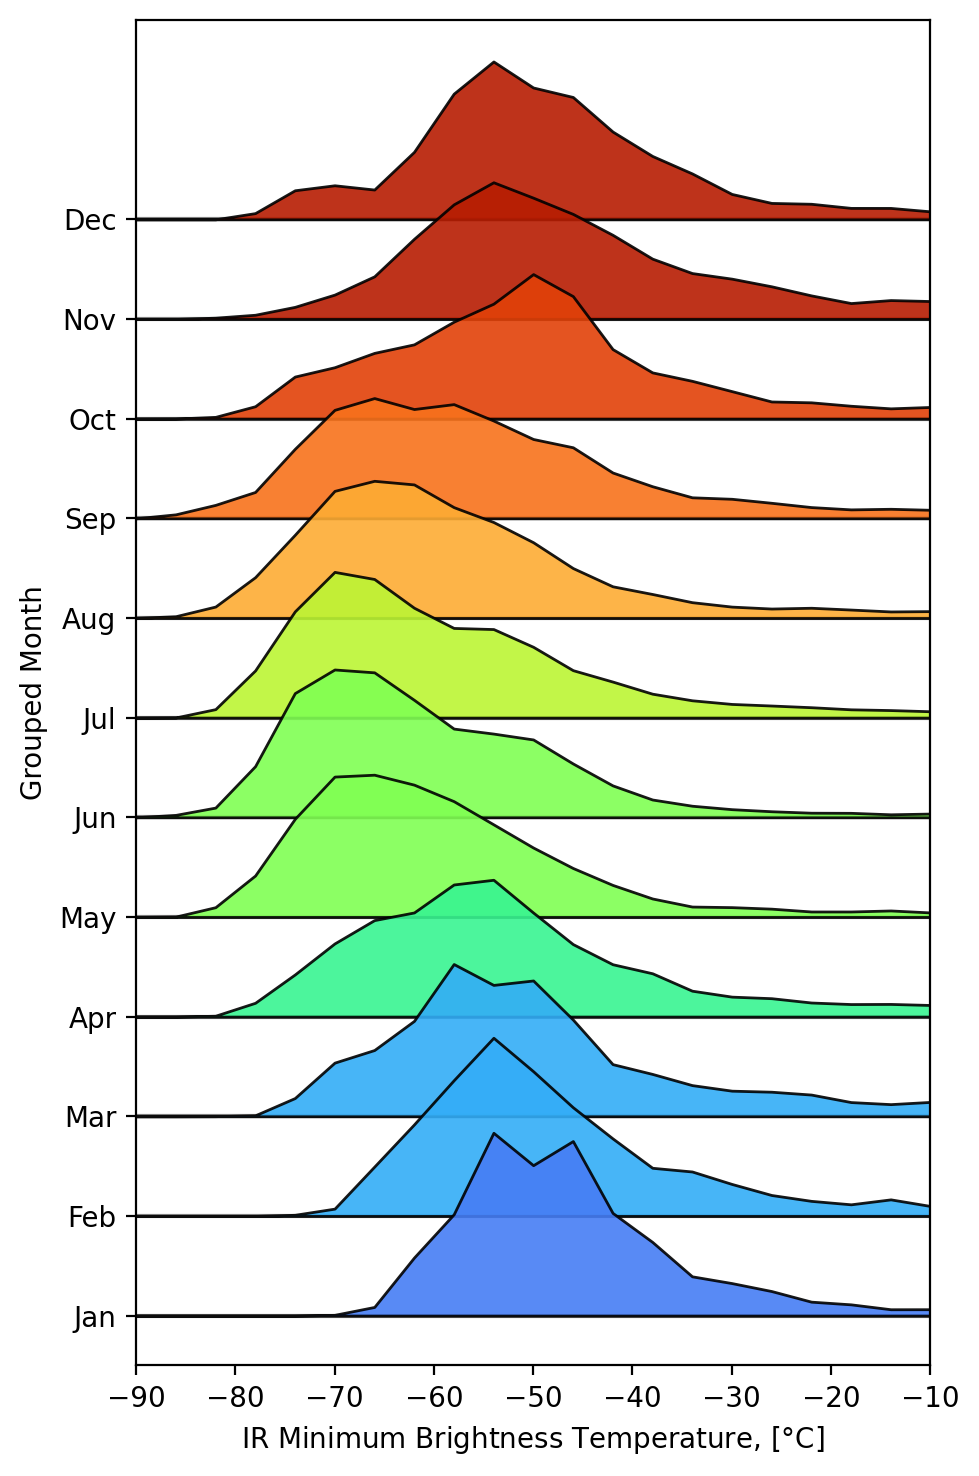

In [9]:
groups = df.q000.groupby(df.index.month)

groups = list(groups)
groups = groups[::-1]

# プロットの設定
bins = np.arange(-100, 0, 4)
mids = np.arange(-98, -2, 4)
cmap = mpl.cm.turbo
bounds = np.arange(0, 1.3, 0.1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")
scalarMap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# プロット
fig, ax = plt.subplots(figsize=(5, 7.5))
# 月毎にプロット（重ならないように縦にずらしていく）
for idx, group in groups:
    # ヒストグラムを作成して月毎に正規化
    c, b = np.histogram(group.values, bins=bins)
    c = c / c.sum()
    # 分布図をプロット
    ax.axhline((idx / 10), color="k", zorder=0, alpha=0.5)
    ax.fill_between(
        mids,
        (idx / 10),
        c + (idx / 10),
        alpha=0.9,
        facecolor=scalarMap.to_rgba((idx / 10)),
        edgecolor="k",
    )

# 軸の設定
ax.set_xlim([-90, -10])
ax.set_yticks(np.arange(0, 1.3, 0.1))
ax.set_ylim([0.05, 1.4])
ax.set_yticklabels(
    [
        "",
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]
)

# ラベル
ax.set_xlabel(r"IR Minimum Brightness Temperature, [$\degree$C]")
ax.set_ylabel("Grouped Month")

plt.tight_layout()

夏の赤外画像では輝度温度が下がり雲頂が高くなる傾向があります。つまり強い嵐に対応しているでしょう。

論文で説明した方法でデータを分割してみましょう。データセットは次のように分割していました。

- 訓練データ: 2017-01-01 から 2090-06-01
- 検証・テストデータ: 2019-06-01 から 2019-12-31 の期間からランダムに選ぶ


In [10]:
# 訓練データの期間を取り出す
train_time_range = slice("2017-01-01", "2019-06-01")
df_train = df[train_time_range]

# 検証、テストデータの候補となる期間を取り出す
other_time_range = slice("2019-06-01", "2019-12-31")
df_other = df[other_time_range]

# 乱数のシードを固定する（再現性のため）
np.random.seed(seed=42)
# df_other のインデックスのリストをつくる
idx = np.arange(0, len(df_other))
# 半分のサイズで検証データのインデックスをランダムにサンプリング
idx_v = np.random.choice(idx, size=len(df_other) // 2, replace=False)
# 残りをテストデータのインデックスにする
idx_t = np.setdiff1d(idx, idx_v)

# 検証データを取り出す
df_validation = df_other.iloc[idx_v]
# 残りをテストデータにする
df_test = df_other.iloc[idx_t]

検証データとテストデータの数が同じことを確認しましょう。


In [11]:
df_validation.shape, df_test.shape

((86338, 10), (86338, 10))

### Step 3: ランダム分割

データセットの分割に複雑な条件を課さずに、単純にランダムに分割すればよい場合は scikit-learn の関数を利用するのが簡単です。
scikit-learn では入力データを `[サンプル数, 特徴量数]`の形状の NumPy 行列で、出力データ（ラベル）を `[サンプル数]` の形状の NumPy 行列（配列）で扱います。
scikit-learn のドキュメントでは `X`, `y` で書かれている変数です。


In [12]:
# scikit-learn から関数をインポート
from sklearn.model_selection import train_test_split

#### 入力行列 X の作成
# event列を削除
df_noenvet = df.drop(columns="event")
# NumPy行列に変換
X = df_noenvet.to_numpy()

#### 出力行列 y の作成
# c列（雷の数）列をNumPy配列として取得
y = df_label.c.values

# train_test_split で訓練データとその他データに分割（scikit-learnでは検証データは考えない）
# テストデータのサイズを割合で指定する
X_train, X_other, y_train, y_other = train_test_split(
    X, y, test_size=0.33, random_state=42  # random_state で乱数シードを固定
)

# その他データを同様に半分に分割
X_validation, X_test, y_validation, y_test = train_test_split(
    X_other, y_other, test_size=0.5, random_state=42
)

# サイズのチェック
X_train.shape, X_validation.shape, X_test.shape

((414872, 9), (102170, 9), (102171, 9))

ここまで IR 画像の最低輝度温度のパーセンタイルを例にして 1 変数のデータセットの分割方法を見てきました。
まだ変数は 3 種類残っています（1 変数につき 9 パーセンタイルの特徴量に変換したので特徴量は全部で 36 個です）。
4 種類の変数をまとめて分割するユーティリティ関数を用意しているのでこの関数を利用してデータを分割しましょう。
どのように分割しているか、興味のある人は `aux_function.py` にある `load_n_combine_df` 関数を見てみてください。

データセットは連続するタイムステップの画像を 1 事例とした画像のまとまりで作られています。
論文の 3.b 節で説明したように検証データとテストデータが同じ事例にならないように（相関を持たないように）するため、
単純にランダムサンプリングして分割するのではなく、隔週となるようにサンプリングして同じ事例で分割しないようにします。


In [13]:
# import some helper functions for our other directory.
import sys

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df

(X_train, y_train), (X_validation, y_validation), (X_test, y_test) = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 36, 1),
    class_labels=True,
)

X_train.shape, X_validation.shape, X_test.shape

((446307, 36), (82871, 36), (89716, 36))